In [1]:
import itertools

import numpy as np
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
import pandas as pd
from sparse import COO
import h5py

from lmfit.lineshapes import gaussian

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pathlib import Path

from cosipy.response import FullDetectorResponse, DetectorResponse, ListModeResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy import test_data

from histpy import Histogram, Axes, Axis, HealpixAxis
import mhealpy as hmap
from mhealpy import HealpixMap, HealpixBase
from scoords import Attitude, SpacecraftFrame

from threeML import Model, Powerlaw, Gaussian

03:43:36 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=733256;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=244793;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=210502;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=260040;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=726293;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=504207;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

/Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


03:43:36 INFO      Starting 3ML!                                                                     ]8;id=979361;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=775763;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=851751;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=606404;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=675759;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=26488;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=275130;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=186531;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=658216;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=988736;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=257489;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=580304;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=781864;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=546229;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

03:43:37 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=16293;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=298804;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=6963;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=916927;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=641839;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=995510;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

03:43:37 WARNING   No fermitools installed                                              ]8;id=603443;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=93032;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

03:43:38 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=145602;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=433902;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=41179;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=126791;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=663334;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=323356;file:///Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

In [2]:
sigma_rsp = 1.414

### Creating example spectral response file

In [85]:
# Set initial conditions
nbins = 5

Ei = np.linspace(507, 515, nbins)

R = np.zeros((5,5))
for i in np.arange(5):
    Z = gaussian(x=Ei[i], center=Ei, sigma=sigma_rsp)
    # R[i, :] = np.round(Z / np.sum(Z), 2)
    R[i, :] = np.round(Z, 2)

# adjust = 1 - np.sum(R, axis=0)
# for i in range(nbins):
#     if np.abs(adjust[i]) < 0.001:
#         continue
#     elif np.abs(adjust[i]) - 0.01 < 0.001:
#         R[i, i] += adjust[i]
#     elif np.abs(adjust[i]) - 0.02 < 0.001:
#         R[[i-1,i+1], i] += adjust[i] / 2
#     else:
#         print(i, adjust[i])
#         raise

R[::-1, :]

array([[0.  , 0.  , 0.01, 0.1 , 0.28],
       [0.  , 0.01, 0.1 , 0.28, 0.1 ],
       [0.01, 0.1 , 0.28, 0.1 , 0.01],
       [0.1 , 0.28, 0.1 , 0.01, 0.  ],
       [0.28, 0.1 , 0.01, 0.  , 0.  ]])

In [86]:
np.sum(R, axis=0)

array([0.39, 0.49, 0.5 , 0.49, 0.39])

In [87]:
NuLambdalen = 48

h = Histogram([np.arange(NuLambdalen + 1), np.linspace(506, 516, 6)*u.keV, np.linspace(506, 516, 6)*u.keV], contents=np.tile(R, (NuLambdalen, 1, 1)), unit=u.cm**2, labels=['NuLambda', 'Ei', 'Em'])
for axis in h.axes:
    print(f"Axis {axis.label} has {axis.nbins} bins")

h.contents

Axis NuLambda has 48 bins
Axis Ei has 5 bins
Axis Em has 5 bins


<Quantity [[[0.28, 0.1 , 0.01, 0.  , 0.  ],
            [0.1 , 0.28, 0.1 , 0.01, 0.  ],
            [0.01, 0.1 , 0.28, 0.1 , 0.01],
            [0.  , 0.01, 0.1 , 0.28, 0.1 ],
            [0.  , 0.  , 0.01, 0.1 , 0.28]],

           [[0.28, 0.1 , 0.01, 0.  , 0.  ],
            [0.1 , 0.28, 0.1 , 0.01, 0.  ],
            [0.01, 0.1 , 0.28, 0.1 , 0.01],
            [0.  , 0.01, 0.1 , 0.28, 0.1 ],
            [0.  , 0.  , 0.01, 0.1 , 0.28]],

           [[0.28, 0.1 , 0.01, 0.  , 0.  ],
            [0.1 , 0.28, 0.1 , 0.01, 0.  ],
            [0.01, 0.1 , 0.28, 0.1 , 0.01],
            [0.  , 0.01, 0.1 , 0.28, 0.1 ],
            [0.  , 0.  , 0.01, 0.1 , 0.28]],

           ...,

           [[0.28, 0.1 , 0.01, 0.  , 0.  ],
            [0.1 , 0.28, 0.1 , 0.01, 0.  ],
            [0.01, 0.1 , 0.28, 0.1 , 0.01],
            [0.  , 0.01, 0.1 , 0.28, 0.1 ],
            [0.  , 0.  , 0.01, 0.1 , 0.28]],

           [[0.28, 0.1 , 0.01, 0.  , 0.  ],
            [0.1 , 0.28, 0.1 , 0.01, 0.  ],
       

(<Axes: xlabel='Ei [keV]', ylabel='Em [keV]'>,
 <matplotlib.collections.QuadMesh at 0x2a303faf0>)

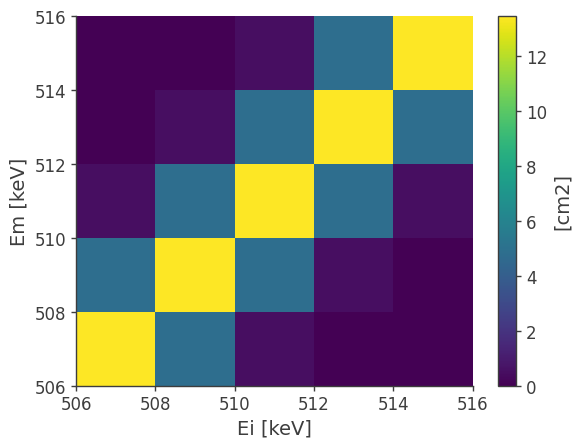

In [88]:
h.project('Ei', 'Em').draw()

In [89]:
h.write('spectral_response_example.h5', overwrite=True)

In [16]:
eps_upper_limit = ((Ei[-1] - Ei[0]) / Ei[0]).round(3) / 2
eps_col_edges = np.linspace(-eps_upper_limit, eps_upper_limit, nbins+1)

In [17]:
for i in range(5):
    Em = (eps_col_edges[i]+eps_col_edges[i+1])/2 * Ei + Ei
    print(Em)
    R[i, :] = gaussian(x=Em, center=Ei, sigma=sigma_rsp)

# R /= np.sum(R, axis=0)
R = np.round(R, 2)

# adjust = 1 - np.sum(R, axis=0)
# print(adjust)
# for i in range(nbins):
#     if np.abs(adjust[i]) < 0.001:
#         continue
#     elif np.abs(adjust[i]) - 0.01 < 0.001:
#         R[2, i] += adjust[i]
#     elif np.abs(adjust[i]) - 0.02 < 0.001:
#         R[[1,3], i] += adjust[i] / 2
#     else:
#         print(i, adjust[i])
#         raise

R = R.transpose(1,0)

R[::-1]

[503.7552 505.7424 507.7296 509.7168 511.704 ]
[505.3776 507.3712 509.3648 511.3584 513.352 ]
[507. 509. 511. 513. 515.]
[508.6224 510.6288 512.6352 514.6416 516.648 ]
[510.2448 512.2576 514.2704 516.2832 518.296 ]


array([[0.02, 0.14, 0.28, 0.14, 0.02],
       [0.02, 0.14, 0.28, 0.14, 0.02],
       [0.02, 0.14, 0.28, 0.14, 0.02],
       [0.02, 0.15, 0.28, 0.15, 0.02],
       [0.02, 0.15, 0.28, 0.15, 0.02]])

In [18]:
NuLambdalen = 48
htransformed = Histogram([np.arange(NuLambdalen+1), np.linspace(506, 516, 6)*u.keV, eps_col_edges], contents=np.tile(R, (NuLambdalen, 1, 1)), unit=u.cm**2, labels=['NuLambda', 'Ei', 'eps'])

In [19]:
htransformed.write('reparam_spectral_response_example.h5', overwrite=True)
# htransformed.contents

(<Axes: xlabel='Ei [keV]', ylabel='eps'>,
 <matplotlib.collections.QuadMesh at 0x106226680>)

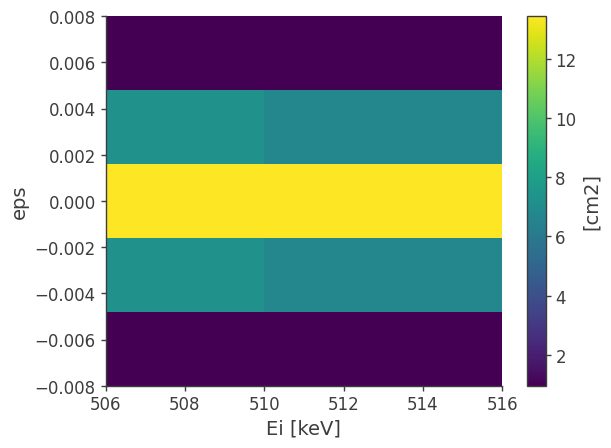

In [20]:
htransformed.project('Ei', 'eps').draw()

### Unbinned MC with example spectral response

In [2]:
image_response = Histogram.open('transformed_response_example.h5')

In [3]:
dr = ListModeResponse(image_response.axes[1:],
                      contents = image_response.slice[1].contents.reshape(5,5),
                      sparse = False,
                      unit = image_response.unit)

In [31]:
Ei0 = 511.1*u.keV
Em0 = 511*u.keV
target = {'Ei': Ei0, 'Em': Em0}
dr.mapping['Em'] = 'eps'
dr.get_interp_response(target)

<Quantity 0.63004011 cm2>

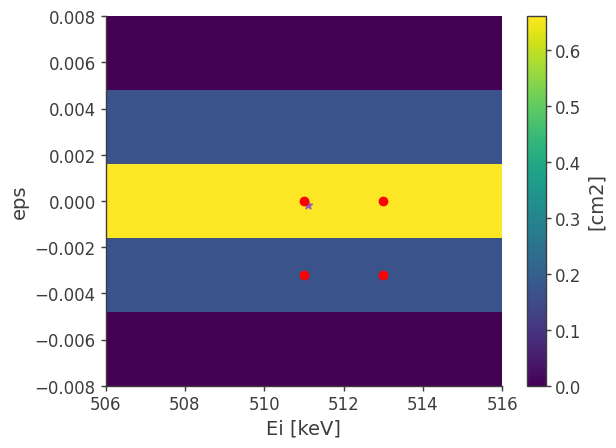

In [33]:
fig, ax = plt.subplots()
dr.draw(ax=ax)
ax.scatter(Ei0, dr.transform_Em_to_eps(Em0, Ei0), marker='*')
for e1 in dr.neighbors['Ei']:
    for e2 in dr.neighbors['eps']:
        ax.scatter(e1, e2, c='r')
plt.show()

In [35]:
dr.axes['Ei'].edges

<Quantity [506., 508., 510., 512., 514., 516.] keV>

In [ ]:
# mu = 511
# sigma_inj = 1
# binedges = np.linspace(506, 516, 6) * u.keV
# bincenters = (binedges[1:]+binedges[:-1])/2

# # Create model 0
# model0 = np.array([0.005,0.005, 0.98, 0.005, 0.005])
# print(model0)

# # Create model 1
# counts, _ = np.histogram(np.random.normal(loc=mu-1, scale=sigma_inj, size=10000), bins=binedges.value)
# model1 = counts / np.sum(counts)
# print(model1)

# # Create model 2
# counts, _ = np.histogram(np.random.normal(loc=mu, scale=sigma_inj, size=10000), bins=binedges.value)
# model2 = counts / np.sum(counts)
# print(model2)

# # Create model 3
# counts, _ = np.histogram(np.random.normal(loc=mu+1, scale=sigma_inj, size=10000), bins=binedges.value)
# model3 = counts / np.sum(counts)
# print(model3)

[0.005 0.005 0.98  0.005 0.005]
[0.0204 0.4754 0.4811 0.0231 0.    ]
[0.001  0.1558 0.6842 0.1572 0.0018]
[0.     0.0236 0.4736 0.4791 0.0237]


In [121]:
# Common model parameters
sigma_inj = 2
binedges = np.linspace(506, 516, 6) * u.keV
bincenters = (binedges[1:]+binedges[:-1])/2

# Simulate events
Ntot = 10
a = np.random.normal(loc=511, scale=np.sqrt(sigma_rsp**2 + sigma_inj**2), size=Ntot) * u.keV
a

<Quantity [509.74699698, 509.83029048, 505.14982751, 514.31033402,
           511.01408609, 510.34000429, 508.9159507 , 508.39782366,
           512.9072772 , 513.92033358] keV>

In [122]:
# As we have injected gaussian data, we can calculate the exact std and mean
np.sqrt(np.std(a)**2 - 1*u.keV**2)

<Quantity 2.42587315 keV>

In [123]:
np.mean(a)

<Quantity 510.45329245 keV>

In [ ]:
# Phase space sampling edges
nbins_mu, nbins_sigma = 30, 30
pred_mu, pred_sigma = np.meshgrid(np.linspace(508, 514, nbins_mu), np.linspace(0.5, 2.5, nbins_sigma))

# List to save all log likelihood values
loglikes = []

for i in range(nbins_mu):
    for j in range(nbins_sigma):
        # Initialize loglike with first term
        loglike = -Ntot

        # Calculate model counts for sampled mu, sigma
        model_counts = gaussian(x=bincenters.value, center=pred_mu[i, j], sigma=pred_sigma[i, j])
        model = model_counts / np.sum(model_counts)

        # Sum over all events
        for Em in a:
            # Temporary variable to sum over Rij*Mj for all j. 
            runningsum = 0
            for model_element, Ei in zip(model, bincenters):
                rsp_val = dr.get_interp_response({'Ei': Ei, 'Em': Em})  # Interpolated response value will be different for different Ei's. TODO: How do you transform this to a linear algebra problem?
                if rsp_val < 1e-3 * u.cm**2:
                    rsp_val = 1e-3 * u.cm**2
                runningsum += rsp_val.value * model_element

            loglike += np.log(runningsum)
        loglikes.append(loglike)

loglike

-35.212950330000226

In [130]:
pred_mu[np.argmax(loglikes)//nbins_mu, np.argmax(loglikes)%nbins_mu], pred_sigma[np.argmax(loglikes)//nbins_sigma, np.argmax(loglikes)%nbins_sigma]

(510.48275862068965, 2.5)

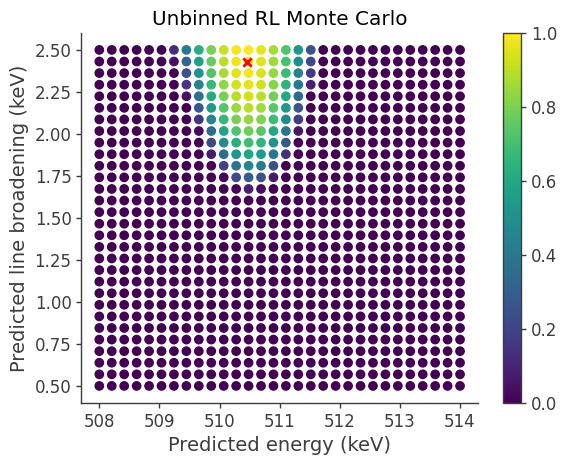

In [131]:
plt.scatter(pred_mu, pred_sigma, c=loglikes, vmin=-30)
plt.xlabel('Predicted energy (keV)')
plt.ylabel('Predicted line broadening (keV)')
plt.title('Unbinned RL Monte Carlo')
plt.scatter(np.mean(a).value, np.sqrt(np.std(a).value**2 - sigma_rsp**2), marker='x', c='r')
plt.colorbar()
plt.show()

### Create example full response file

In [90]:
image_response = Histogram.open('spectral_response_example.h5')

In [34]:
mEq = HealpixBase(order=1, scheme='ring')

In [35]:
mEq.order, mEq.nside, mEq.npix

(1, 2, 48)

In [36]:
theta0 = np.deg2rad(90)
phi0 = np.deg2rad(45)
sigma = np.deg2rad(1)        # Gaussian on sphere with 1-sigma width = 1 deg
disc_pix = mEq.query_disc(hmap.ang2vec(theta0, phi0), 3*sigma)

In [37]:
disc_pix

array([], dtype=int64)

In [38]:
m = HealpixMap.moc_from_pixels(mEq.nside, disc_pix, density=True)

print("NUNIQ pixels in MOC map: {}".format(m.npix))
print("Equivalent single-resolution pixels: {}".format(mEq.npix))

# Fill the map. This code would look exactly the same if this were a
# single-resolution map
for pix in range(m.npix):

    theta,phi = m.pix2ang(pix)

    m[pix] = np.exp(-((theta-theta0)**2 + (phi-phi0)**2) / 2 / sigma**2)

NUNIQ pixels in MOC map: 12
Equivalent single-resolution pixels: 48


In [39]:
image_response.contents.shape

(48, 5, 5)

In [91]:
def HealpixBase_to_h5(m, hist, h5_file):
    with h5py.File(h5_file, 'w') as hf:
        drm = hf.create_group('DRM')
        data = hist.contents
        hf['DRM'].attrs['UNIT'] = str(data.unit)
        hf['DRM'].attrs['SPARSE'] = False

        axis_grp = drm.create_group('AXES', track_order=True)

        axis = axis_grp.create_dataset('NuLambda', data=np.arange(m.npix+1))
        axis.attrs['DESCRIPTION'] = 'Location of the simulated source in the spacecraft coordinates'
        axis.attrs['NSIDE'] = m.nside
        axis.attrs['SCHEME'] = m.scheme
        axis.attrs['TYPE'] = 'healpix'

        axis = axis_grp.create_dataset('Ei', data=image_response.axes['Ei'])
        axis.attrs['DESCRIPTION'] = 'Initial simulated energy'
        axis.attrs['TYPE'] = 'linear'
        axis.attrs['UNIT'] = str(hist.axes['Ei'].unit)

        # axis = axis_grp.create_dataset('eps', data=image_response.axes['eps'])
        # axis.attrs['DESCRIPTION'] = 'Measured energy'
        # axis.attrs['TYPE'] = 'linear'
        # axis.attrs['UNIT'] = ' '

        axis = axis_grp.create_dataset('Em', data=image_response.axes['Em'])
        axis.attrs['DESCRIPTION'] = 'Measured energy'
        axis.attrs['TYPE'] = 'linear'
        axis.attrs['UNIT'] = str(hist.axes['Em'].unit)

        # axis = axis_grp.create_dataset('Phi', data=np.arange(m.npix))
        # axis.attrs['DESCRIPTION'] = 'Compton angle'
        # axis.attrs['TYPE'] = 'linear'
        # axis.attrs['UNIT'] = str(hist.axes['Phi'].unit)

        # axis = axis_grp.create_dataset('PsiChi', data=np.arange(m.npix+1))
        # axis.attrs['DESCRIPTION'] = 'Location in the Compton Data Space'
        # axis.attrs['NSIDE'] = m.nside
        # axis.attrs['SCHEME'] = m.scheme
        # axis.attrs['TYPE'] = 'healpix'
        
        dset = drm.create_dataset('CONTENTS', data=data.value)

# Example usage
HealpixBase_to_h5(mEq, image_response, 'normparam_full_response_example.h5')

In [59]:
with h5py.File('normparam_full_response_example.h5', mode='r') as file:

    drm = file['DRM']
    unit = u.Unit(drm.attrs['UNIT'])
    sparse = drm.attrs['SPARSE']

    # Axes
    axes = []

    for i, axis_label in enumerate(drm["AXES"]):

        axis = drm['AXES'][axis_label]
        axis_type = axis.attrs['TYPE']

        if axis_type == 'healpix':
            print(np.array(axis))
            axes += [HealpixAxis(edges=np.array(axis),
                                        nside=axis.attrs['NSIDE'],
                                        label=axis_label,
                                        scheme=axis.attrs['SCHEME'],
                                        coordsys=SpacecraftFrame())]

        else:
            axes += [Axis(np.array(axis) * u.Unit(axis.attrs['UNIT']),
                                scale=axis_type,
                                label=axis_label)]

    new_axes = Axes(axes)

    # Init HealpixMap (local coordinates, main axis)
    # HealpixBase.__init__(base=axes['NuLambda'], 
    #                      coordsys=SpacecraftFrame())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]


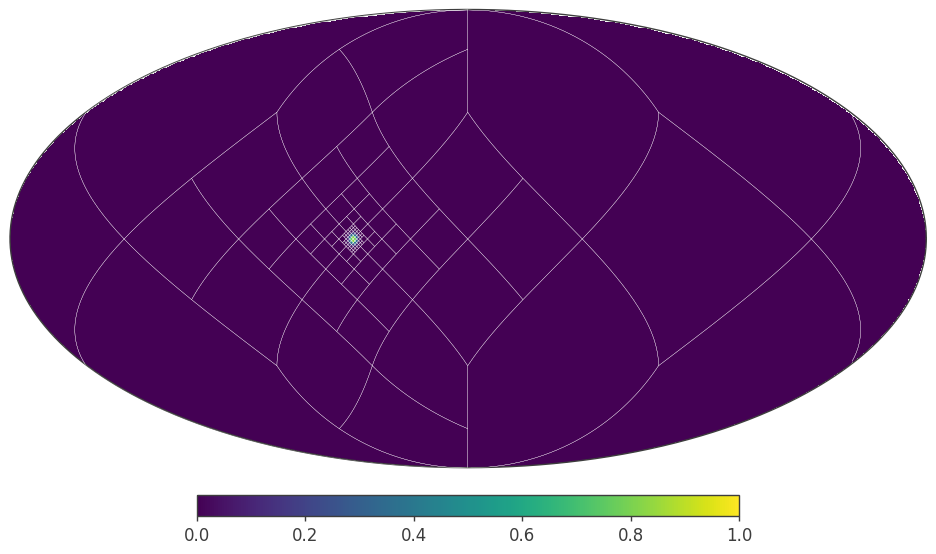

In [ ]:
fig = plt.figure(figsize=(14, 7))
axMoll = fig.add_subplot(projection = "mollview")
m.plot(axMoll, vmin=0, vmax=1)
m.plot_grid(axMoll, color='white', linewidth = .2)
plt.show()

### Load FullDetectorResponse

In [65]:
with FullDetectorResponse.open('reparam_full_response_example.h5') as response:
    dr_re = response.get_interp_response(SkyCoord(lon=0, lat=0, frame=SpacecraftFrame(), unit=u.deg), unbinned=True)

In [66]:
dr_re.axes['eps'].edges

<Quantity [-0.008 , -0.0048, -0.0016,  0.0016,  0.0048,  0.008 ]>

In [67]:
dr_re.axes['Ei'].edges

<Quantity [506., 508., 510., 512., 514., 516.] keV>

In [3]:
with FullDetectorResponse.open('normparam_full_response_example.h5') as response:
    dr_norm = response.get_interp_response(SkyCoord(lon=0, lat=0, frame=SpacecraftFrame(), unit=u.deg), unbinned=True)

In [4]:
dr_norm.mapping['Em'] = 'Em'
dr_norm.axes['Em'].edges

<Quantity [506., 508., 510., 512., 514., 516.] keV>

In [5]:
dr_norm.axes['Ei'].edges

<Quantity [506., 508., 510., 512., 514., 516.] keV>

In [7]:
target = {'Em': 508.5*u.keV, 'Ei': 508.5*u.keV}

# print(dr_re.get_interp_response(target))
print(dr_norm.get_interp_response(target))

0.21250000000000002 cm2


In [10]:
response_path = Path('/Users/penguin/Documents/Grad School/Research/COSI/COSIpy/docs/tutorials/data/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5')

In [26]:
# Define data paths
data_dir = Path("/Users/penguin/Documents/Grad School/Research/COSI/COSIpy/docs/tutorials/data") # Current directory by default. Modify if you can want a different path
ori_path = data_dir / "20280301_3_month.ori"

# Read the full oritation
ori = SpacecraftFile.parse_from_file(ori_path)
scatt_map = ori.get_scatt_map(nside = 16, coordsys = 'galactic')

# define the target coordinates (Crab)
target_coord = SkyCoord(184.5551, -05.7877, unit = "deg", frame = "galactic")

In [ ]:
# # get the target movement in the reference frame attached to the detector
# target_in_sc_frame = ori.get_target_in_sc_frame(target_name = "Crab", target_coord = target_coord)

# # To get the dwell time map, look at the DetectorResponse.ipynb tutorial notebook
# dwell_time_map = ori.get_dwell_map(response = response_path, src_path = target_in_sc_frame) # Dwell time map is in SpacecraftFrame() L.409 (SpacecraftFile.py)

# with FullDetectorResponse.open(response_path) as response:
#     psr = response.get_point_source_response(exposure_map=dwell_time_map)

In [ ]:
with FullDetectorResponse.open(response_path) as response:
    psr = response.get_point_source_response(scatt_map = scatt_map, coord = target_coord)

In [19]:
with FullDetectorResponse.open(response_path) as response:
    print(f"Pixel 0 centered at {response.pix2skycoord(0)}")
    dr = response[0]
    data = response._file['DRM']['CONTENTS'][0]
    dr = ListModeResponse(response.axes[1:], contents=data, unit=response.unit)   
    dr = response.get_interp_response(SkyCoord(lon=0, lat=0, frame=SpacecraftFrame(), unit=u.deg), unbinned=True)

Pixel 0 centered at <SkyCoord (SpacecraftFrame: attitude=None, obstime=None, location=None): (lon, lat) in deg
    (45., 84.14973294)>


In [31]:
with FullDetectorResponse.open(response_path) as response:
    print(Histogram([Axis(np.arange(target_coord.size+1))] + list(response.axes[1:]), 
                    unit = response.unit * scatt_map.unit))
    print(response.axes['PsiChi'].coordsys)
    response.axes['PsiChi'].coordsys = target_coord.frame
    print(response.axes['PsiChi'].coordsys)

<SpacecraftFrame Frame (attitude=None, obstime=None, location=None)>
<Galactic Coordinate: (l, b) in deg
    (184.5551, -5.7877)>


In [30]:
dr.axes['PsiChi'].coordsys

<SpacecraftFrame Frame (attitude=None, obstime=None, location=None)>

In [25]:
Ei0 = 511.*u.keV
Em0 = 600*u.keV
Phi0 = 12*u.deg
PsiChi0 = 386

target = {'Ei': Ei0, 'Em': Em0, 'Phi': Phi0, 'PsiChi': PsiChi0}
interpolated_response_value = dr.get_interp_response(target)

interpolated_response_value

<Quantity 1.49006128e-06 cm2>

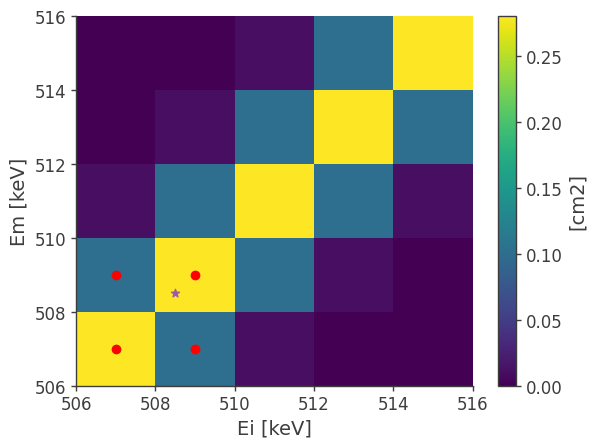

In [8]:
dr = dr_norm
label1 = 'Ei'
label2 = 'Em'

fig, ax = plt.subplots()
dr.project(label1, label2).draw(ax=ax)
ax.scatter(target[label1], target[label2], marker='*')
for e1 in dr.neighbors[label1]:
    for e2 in dr.neighbors[label2]:
        ax.scatter(e1, e2, c='r')
plt.show()